<h1><center> Machine Learning Engineering nano Degree </center></h1>
<h3><center>  Capstone Project - Rémi Ang </center></h3>

<h2><center>Flowers recognition</center></h2>

![Daisy](./images_samples/813445367_187ecf080a_n.jpg)

<a id="top"></a>

---

** Introduction **

This aim of this notebook is to define and train a Deep Convolutional Network able to recognize flower species based on a picture. 

The dataset is the ["Flowers Recognition"](https://www.kaggle.com/alxmamaev/flowers-recognition) dataset from Kaggle donated by [Alexander Mamaev](https://www.kaggle.com/alxmamaev).

The dataset contains 4362 pictures devided in 5 classes: Daisy, Dandelion, Rose, Sunflower, Tulip 

---

**Notebook summary:**

* [Step 1](#step1) : Imports and print packages version
* [Step 2](#step2) : Scan the flowers pictures dataset
* [Step 3](#step3) : Visualize some pictures
* [Step 4](#step4) : Flowers classes distribution
* [Step 5](#step5) : stratified Train/test split the data and copy pictures in train/test folders
* [Step 6](#step6) : Data augmentation - create images generators
* [Step 7](#step7) : get the model

<a id="step1"></a>
## 1. imports
[to the top](#top)

In [26]:
# # reload modules
# import importlib

# import custom_utils
# importlib.reload(custom_utils)

# from custom_utils import print_list, plot_images, flowersDistBarplot, copy_pictures

In [4]:
print("loading basic packages...")
from time import time
start = time()

import sys
import os

#import glob
import urllib
import random
import itertools
from shutil import rmtree

from tqdm import tqdm

print("loading custom utilities package...")
from custom_utils import print_list, plot_images, flowersDistBarplot, copy_pictures, plotTrainingHistory

print("loading plotting packages...")
import matplotlib as mlp
%matplotlib inline  

import matplotlib.pyplot as plt
#plt.style.use('ggplot')

import seaborn as sns

print("loading Numpy...")
import numpy as np

print("loading Sklearn...")
from sklearn import __version__ as sklearn_version
from sklearn.datasets import load_files 
from sklearn.model_selection import train_test_split

print("loading Keras...")
# set TensorFlow as Keras backend
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras import __version__ as keras_version
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import Xception
import keras.applications.xception as xception 
#from keras.applications.vgg16 import VGG16
#from keras.applications.resnet50 import ResNet50
#from keras.applications.inception_v3 import InceptionV3

from keras.layers import Flatten, Dense, Dropout
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint  

print("loading TensorFlow...")
from tensorflow import __version__ as tf_version

print("loading OpenCV...")
import cv2

# define random seed
random_seed = 6

print("all imports done (time elapsed: {:.2f} s)".format(time() - start))

loading basic packages...
loading custom utilities package...
loading plotting packages...
loading Numpy...
loading Sklearn...
loading Keras...


/Users/remi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


loading TensorFlow...
loading OpenCV...
all imports done (time elapsed: 2.29 s)


In [5]:
# print packages version

print("Packages versions:")
print("------------------")
print("Python: {}".format(sys.version))
print("Matplotlib : {}".format(mlp.__version__))
print("Seaborn : {}".format(sns.__version__))
print("Numpy : {}".format(np.__version__))
print("Scikit-learn : {}".format(sklearn_version))
print("Keras : {}".format(keras_version))
print("Keras backend: {}".format(os.environ['KERAS_BACKEND']))
print("Tensor Flow : {}".format(tf_version))
print("openCV : {}".format(cv2.__version__))

Packages versions:
------------------
Python: 3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 12:04:33) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
Matplotlib : 2.1.2
Seaborn : 0.8.1
Numpy : 1.14.0
Scikit-learn : 0.19.1
Keras : 2.1.5
Keras backend: tensorflow
Tensor Flow : 1.1.0
openCV : 3.4.1


<a id="step2"></a>
## 2. Scan the flowers pictures dataset
[to the top](#top)

In [8]:
path = "./flowers"
if not os.path.exists(path):
    raise Exception("The Flowers Dataset is missing!") 

blacklist_file = "blacklist.txt" # list of files to be removed drm the dataset

#read blacklist
print("\nreading blacklist: {}...".format(blacklist_file))
with open(blacklist_file, 'r') as f:
    blacklist = f.readlines()
blacklist = [path + s.strip() for s in blacklist]
print("{} files to discard defined in blacklist".format(len(blacklist)))

print("\nCollecting files from data folder : {}".format(path))
data = load_files(path, load_content=False)
all_flowers_files = np.array([s.replace('\\', '/') for s in data["filenames"]])
print("{} flower pictures found".format(all_flowers_files.shape[0]))

# identify blacklist indexes
isvalid_file = [True if f not in blacklist else False for f in all_flowers_files]
flowers_files = all_flowers_files[isvalid_file]
print("{} flower pictures kept after black list filtering".format(flowers_files.shape[0]))

# flowers_targets = np_utils.to_categorical(data["target"],5)
flowers_targets = data["target"][isvalid_file]
flowers_target_names = data["target_names"]

print()
print_list(flowers_target_names, 'types of flower found')


reading blacklist: blacklist.txt...
1059 files to discard defined in blacklist

4327 flower pictures found
3269 flower pictures kept after black list filtering

5 types of flower found:
	o daisy
	o dandelion
	o rose
	o sunflower
	o tulip


<a id="step3"></a>
##  3. Visualize some pictures
[to the top](#top)

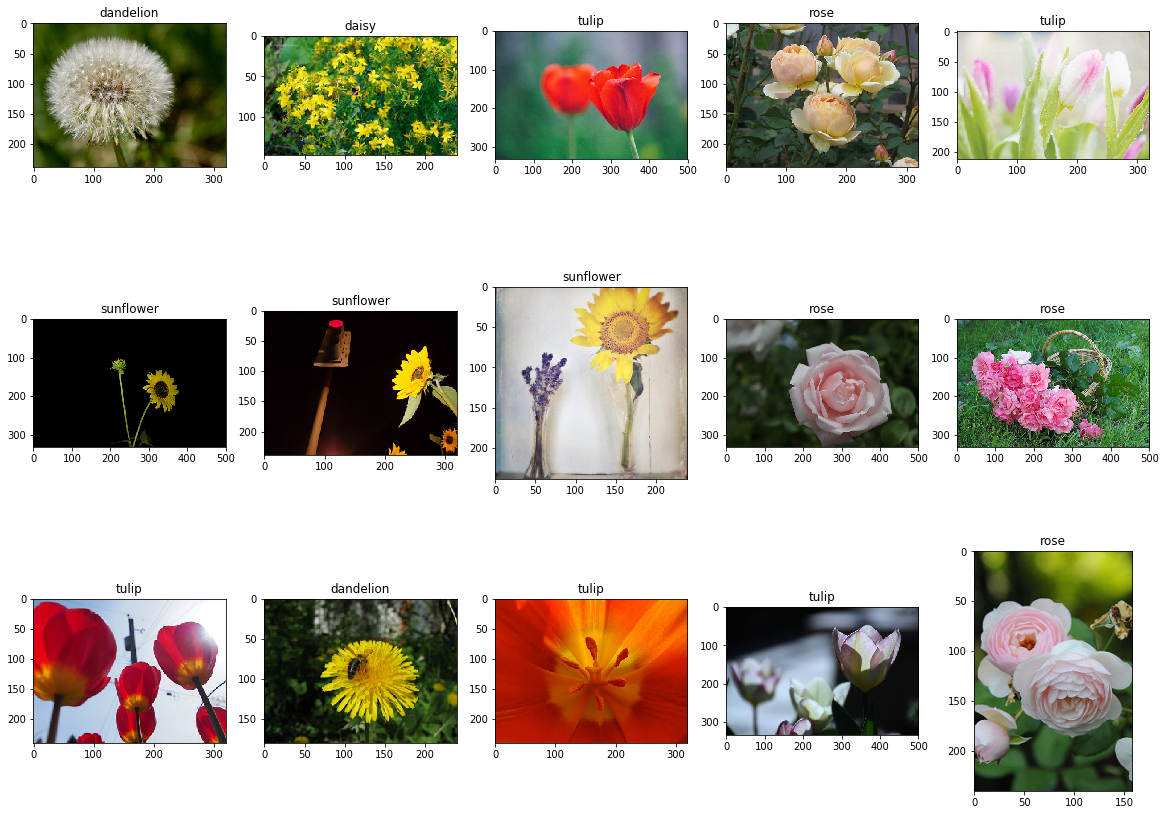

In [5]:
np.random.seed(random_seed)
n_samples = 15
sample_idx = np.random.choice(list(range(flowers_files.shape[0])), n_samples)
sample_files = flowers_files[sample_idx]
sample_titles = [flowers_target_names[i] for i in flowers_targets[sample_idx]]

plot_images(sample_files, sample_titles)

** Note: ** the flower pictures are of various sizes, angle of view, light conditions. We can also observe that some pictures have been artistically post-processed, adding colour filters altering the original colour of the flower. 
In some case the flower is not the main subject of the picture, as such we often have on the picture non-flower subjects such as insects, babies, wine bottle, etc. 

The Dandelion flower appear in 2 states: the yellow-orange flower and the whithe spherical seeds head "blowball" form.

### black listed picture samples

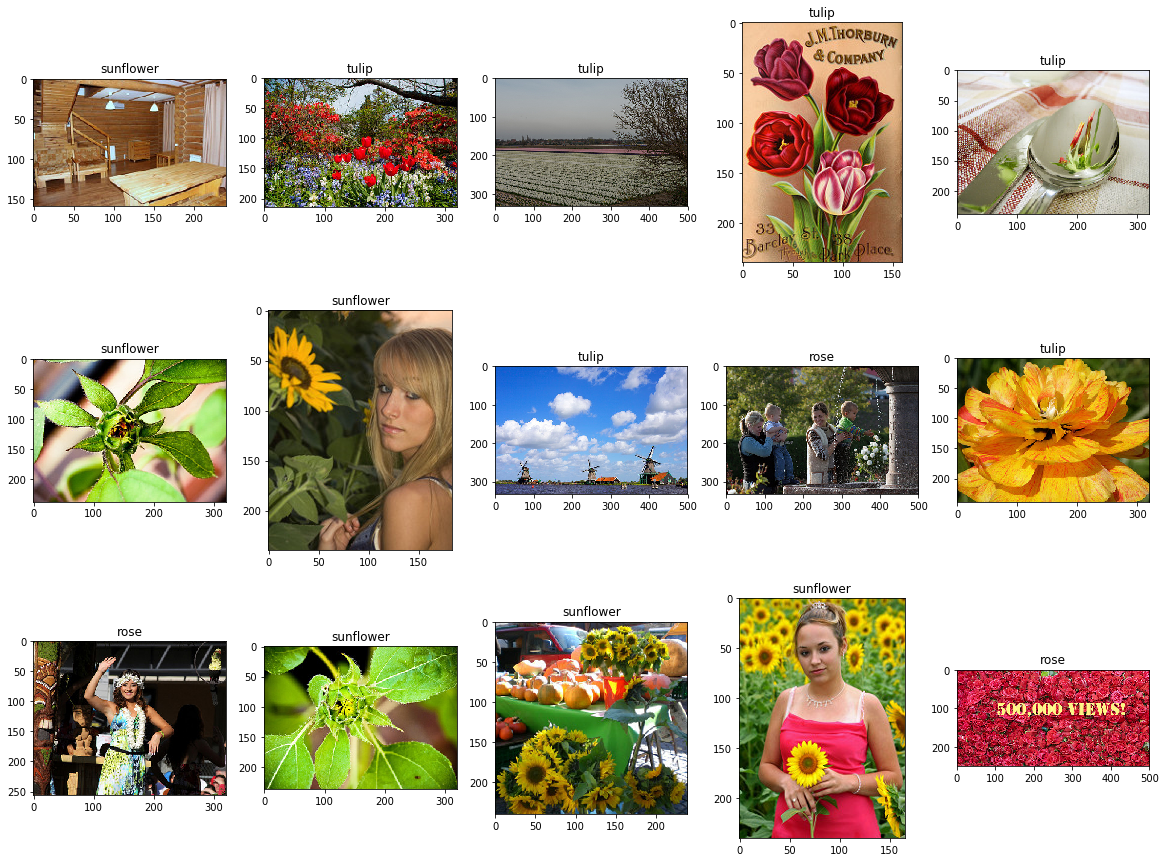

In [6]:
np.random.seed(4)
n_samples = 15
sample_idx = np.random.choice(list(range(len(blacklist))), n_samples)
sample_files = np.array(blacklist)[sample_idx]

sample_titles = [];
for sample_file in sample_files:
    idx = np.where(all_flowers_files == sample_file)
    sample_titles.append(flowers_target_names[data["target"][idx][0]])
    

print("")
plot_images(sample_files, sample_titles)

<a id="step4"></a>
## 4. Flowers Classes distribution
[to the top](#top)

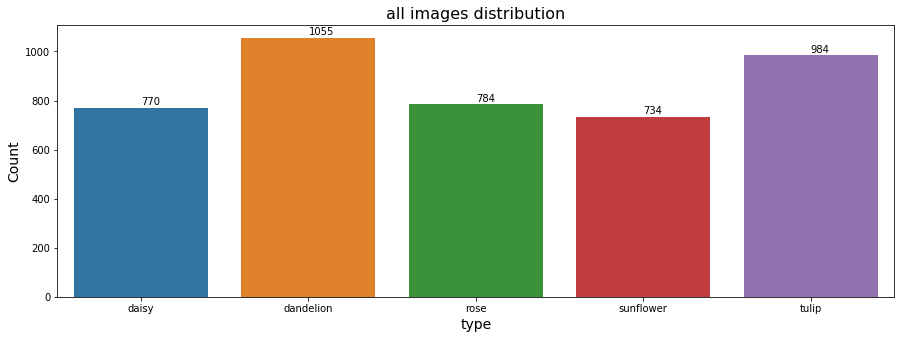

In [10]:
# plot original distribution
flowersDistBarplot(data["target"], flowers_target_names, "all images distribution")

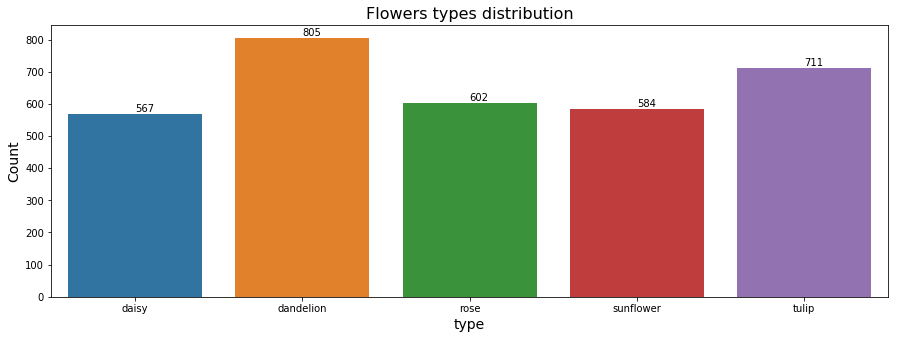

In [12]:
flowersDistBarplot(flowers_targets, flowers_target_names, "Flowers types distribution")

** Note : ** classes distribution is slightly unbalanced. 

[keras applications reference page](https://keras.io/applications/)

<a id="step5"></a>
## 5. stratified Train/Valid/Test split of the dataset
[to the top](#top)

** Note ** : stratified split is required to preserve a uniform distirbution of each class in both train and tests split

In [19]:

np.random.seed(random_seed)

test_size = .15

print("Splitting train+valid/test flower files (split ratio: {} / {} %)...".format((1-test_size) * 100, test_size * 100))
flowers_files_train_valid, flowers_files_test, flowers_targets_train_valid, flowers_targets_test = train_test_split(
    flowers_files, flowers_targets, 
    test_size = test_size, 
    stratify=flowers_targets,
    random_state=random_seed)


valid_size = .1
print("Splitting train/valid flower files (split ratio: {} / {} %)...".format((1-valid_size) * 100, valid_size * 100))
flowers_files_train, flowers_files_valid, flowers_targets_train, flowers_targets_valid = train_test_split(
    flowers_files_train_valid, flowers_targets_train_valid, 
    test_size = valid_size, 
    stratify=flowers_targets_train_valid,
    random_state=random_seed)

print("{} training flowers files.".format(flowers_files_train.shape[0]))
print("{} validation flowers files.".format(flowers_files_valid.shape[0]))
print("{} testing flowers files.".format(flowers_files_test.shape[0]))

Splitting train+valid/test flower files (split ratio: 85.0 / 15.0 %)...
Splitting train/valid flower files (split ratio: 90.0 / 10.0 %)...
2500 training flowers files.
278 validation flowers files.
491 testing flowers files.


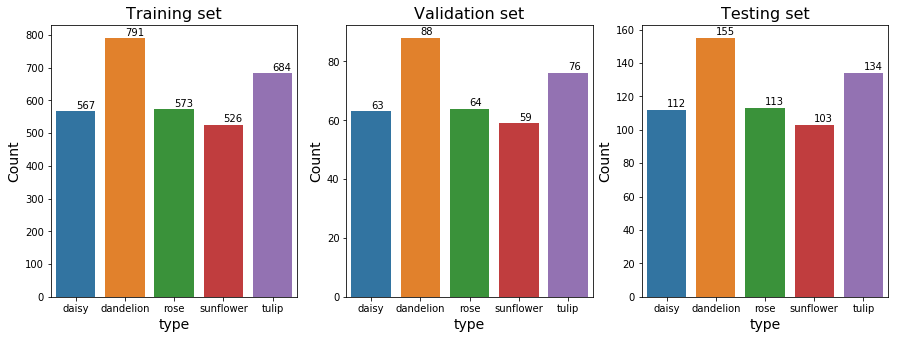

In [27]:
flowersDistBarplot([flowers_targets_train,flowers_targets_valid,flowers_targets_test],
                   flowers_target_names, 
                   ["Training set",  "Validation set", "Testing set"])

## 5. 2 Load the datasets in memory, transform targets to categorical

In [28]:
def loadimg(path):
    """
    load and resize an image
    return a (299, 299, 3) array
    """
    img = cv2.imread(path)
    img_r = cv2.resize(img, (299, 299))
    return img_r

x_train = np.array([loadimg(f) for f in tqdm(flowers_files_train)]).reshape(-1, 299, 299, 3)
y_train =  np_utils.to_categorical(flowers_targets_train)
print("training set shape : {}".format(x_train.shape))

x_valid = np.array([loadimg(f) for f in tqdm(flowers_files_valid)]).reshape(-1, 299, 299, 3)
y_valid =  np_utils.to_categorical(flowers_targets_valid)
print("training set shape : {}".format(x_train.shape))

x_test = np.array([loadimg(f) for f in tqdm(flowers_files_test)]).reshape(-1, 299, 299, 3)
y_test =  np_utils.to_categorical(flowers_targets_test)
print("testing set shape : {}".format(x_test.shape))

100%|█████████████████████████████████████| 3141/3141 [00:15<00:00, 205.99it/s]


training set shape : (3141, 299, 299, 3)


100%|███████████████████████████████████████| 350/350 [00:01<00:00, 227.83it/s]


training set shape : (3141, 299, 299, 3)


100%|███████████████████████████████████████| 617/617 [00:02<00:00, 227.46it/s]


testing set shape : (617, 299, 299, 3)


## 5.3  copy flower pictures in train/test folders

In [11]:
# create data sub-directories

# data_root = os.path.join('.','data')
# subdirs = ['train', 'test']

# if os.path.exists(data_root):
#     print("Warning: {} folder already exist and will be overwritten".format(data_root))
#     rmtree(data_root)
# for d, t in itertools.product(subdirs, flowers_target_names):
#     path = os.path.join(data_root, d, t)
#     print("create new folder : {}".format(path))
#     os.makedirs(path)
    
# # copy pictures in data/ subdirectories
    
# copy_pictures(flowers_files_train, 'train', data_root)
# copy_pictures(flowers_files_test, 'test', data_root)

<a id="step6"></a>
## 6. Data augmentation - Create image generators
[to the top](#top)

In [29]:
batch_size = 32 # default: 32

# training data generator - scaling and data augmentation
print("Initializing training data generator...")
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

train_datagen.fit(x_train)
# train_generator = train_datagen.flow_from_directory(
#         os.path.join('.', data_root, 'train'),  
#         target_size=(150, 150),  # all images will be resized to 150x150
#         batch_size=batch_size,
#         class_mode='categorical')

# validation data generator - scaling and data augmentation
print("Initializing validation data generator...")
valid_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

valid_datagen.fit(x_valid)

# test data generator - scaling only
print("Initializing testing data generator...")
test_datagen = ImageDataGenerator(rescale=1./255)
test_datagen.fit(x_test)

# test_generator = test_datagen.flow_from_directory(
#        os.path.join('.', data_root, 'test'),  
#         target_size=(150,150),
#         batch_size=batch_size,
#         class_mode='categorical')

Initializing training data generator...
Initializing validation data generator...
Initializing testing data generator...


<a id="step7"></a>
## 7. Convolutional Neural Network, Transfer Learning from Xception
[to the top](#top)

[reference: "flowers are mesmerizing", *aakashnain*](https://www.kaggle.com/aakashnain/flowers-are-mesmerizing)

![Xception](https://i.imgur.com/tA2qDIQ.jpg)

In [13]:
# load the model (download the weights if necessary)
# include_top : whether to include the 3 fully-connected layers at the top of the network

#base_model_name = 'ResNet50'    # size: 99MB Top-5 Accuracy: 0.929
#base_model_name = 'InceptionV3' # size: 92MB Top-5 Accuracy: 0.944
base_model_name = 'Xception'    # size: 88MB Top-5 Accuracy: 0.945

base_model = Xception(weights='imagenet', include_top=False, input_shape=(299,299,3))

In [15]:
# freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False   
    
# new layers:
# -----------

x = Flatten()(base_model.output)
x = Dense(500, activation='relu', name='fc1')(x)
x = Dropout(0.5)(x)
x = Dense(5, activation='softmax', name='fc2')(x)

# Model class API, take tensor in input and tensor in output
model = Model(inputs=base_model.input, outputs=x)

# Adam optimizer attributes:
# --------------------------
# lr: float >= 0. Learning rate.
# beta_1: float, 0 < beta < 1. Generally close to 1.
# beta_2: float, 0 < beta < 1. Generally close to 1.
# epsilon: float >= 0. Fuzz factor. If None, defaults to K.epsilon().
# decay: float >= 0. Learning rate decay over each update.
# amsgrad: boolean. Whether to apply the AMSGrad variant of this algorithm from the paper "On the Convergence of Adam and Beyond".

opt = Adam(lr = 1e-3, decay=1e-6)

model.compile(loss = 'categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 299, 299, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 149, 149, 32)  864                                          
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, 149, 149, 32)  128                                          
__________________________________________________________________________

<a id="step8"></a>
## 8. Train the Model
[to the top](#top)

In [ ]:
batch_size = 8
epochs = 2 

best_weights_h5 = 'saved_models/weights.best.flowers_recognition.{}.hdf5'.format(base_model_name)

checkpointer = ModelCheckpoint(filepath=best_weights_h5, 
                               verbose=1, save_best_only=True)

training_hist = model.fit_generator(train_datagen.flow(x_train, y_train, batch_size=batch_size),
        steps_per_epoch=x_train.shape[0] // batch_size,
        epochs=epochs, 
        verbose=1, 
        callbacks=[checkpointer],
        validation_data=valid_datagen.flow(x_valid, y_valid, batch_size=batch_size),
        validation_steps=x_valid.shape[0] // batch_size)
            

In [ ]:
# plot training history

plotTrianingHistory(training_hist)

<a id="step9"></a>
## 9. Load the Model with the Best Validation Accuracy
[to the top](#top)

In [ ]:
# load the weights that yielded the best validation accuracy

if "best_weights_h5" not in locals():
    base_model_name = 'Xception'
    best_weights_h5 = 'saved_models/weights.best.flowers_recognition.{}.hdf5'.format(base_model_name)

model.load_weights(best_weights_h5)

<a id="step10"></a>
## 10. Calculate Classification Accuracy on Test Set
[to the top](#top)

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])

In [14]:
# use Xception to make a prediction

# from keras.preprocessing.image import img_to_array
# from keras.preprocessing.image import load_img

# if "xception_model" not in locals():
#     xception_model = Xception(weights='imagenet',include_top=True, input_shape=(299,299,3))

# img = load_img(np.random.choice(flowers_files_test), target_size=(299, 299))

# plt.imshow(img)

# x = img_to_array(img)
# x = np.expand_dims(x, axis=0)
# x = xception.preprocess_input(x)
# preds = xception_model.predict(x)
# print('Predicted:', xception.decode_predictions(preds, top=3)[0])